In [285]:
import torch, os
os.environ.setdefault("PYTORCH_ENABLE_MPS_FALLBACK", "1")
print("MPS built:", torch.backends.mps.is_built())
print("MPS avail:", torch.backends.mps.is_available())
device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using:", device)

MPS built: True
MPS avail: True
Using: mps


In [286]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")  # nuke all warnings



In [287]:

def winsorize_simple(df: pd.DataFrame, lower: float = 0.005, upper: float = 0.995, numeric_only: bool = True) -> pd.DataFrame:
    """
    Clip each (numeric) column to its [lower, upper] quantiles computed on *this* df.
    Returns a new DataFrame.
    """
    X = df.copy()
    cols = X.select_dtypes(include="number").columns if numeric_only else X.columns
    ql = X[cols].quantile(lower)
    qu = X[cols].quantile(upper)
    X[cols] = X[cols].clip(lower=ql, upper=qu, axis=1)
    return X

In [288]:
def hygiene(X, pct = 0.2):
    out = X.copy()
    drop_cols = []
    for col in out.columns:
        if out[col].isna().sum()/len(out) > pct:
            drop_cols.append(col)
    out = out.drop(columns=drop_cols)
    return out, drop_cols

In [289]:
def select_columns_for_rolling(
    X_tr: pd.DataFrame, y_tr,
    *,
    mean_windows: tuple[int, ...] = (5, 20),
    std_windows:  tuple[int, ...] = (5, 20),
    top_mean: int = 30,
    top_std:  int = 15,
    margin: float = 0.005,      # require the rolled feature to beat base corr by this much
) -> dict:
    """
    Decide which columns to build rolling MEANs / STDs for, using TRAIN ONLY.

    Strategy:
      - Baseline abs Pearson corr of each raw column with y_tr.
      - For each column, compute abs corr of rolling mean over mean_windows (INCLUDES t) with y_tr.
      - For std: use max(abs corr with y_tr, abs corr with |y_tr|) as vol->return link can be asymmetric.
      - Add a stability check (first half vs second half); score = r_all + 0.5*min(r_half1,r_half2).
      - Keep columns whose best rolling beats raw by >= margin.
      - Return top_mean by mean score, top_std by std score.

    Returns:
      {
        "mean": [(col, w), ...],
        "std":  [(col, w), ...],
        "baseline_corr": {col: abs_corr_raw, ...}
      }
    """
    X = X_tr.select_dtypes(include=[np.number]).astype("float32")
    y = np.asarray(y_tr, dtype=float).reshape(-1)
    T = len(X)
    split = max(1, int(T * 0.5))

    def _safe_corr(a, b):
        a = np.asarray(a, float); b = np.asarray(b, float)
        m = np.isfinite(a) & np.isfinite(b)
        if m.sum() < 20: return 0.0
        a = a[m] - a[m].mean(); b = b[m] - b[m].mean()
        den = np.sqrt((a*a).sum()) * np.sqrt((b*b).sum())
        return 0.0 if den == 0 else float((a*b).sum() / den)

    base_corr = {c: abs(_safe_corr(X[c], y)) for c in X.columns}

    mean_candidates = []
    for c in X.columns:
        if 'D' in c:
            continue
        best = None
        for w in mean_windows:
            r = X[c].rolling(w, min_periods=w).mean()     # includes t
            r_all = abs(_safe_corr(r, y))
            r_1   = abs(_safe_corr(r.iloc[:split], y[:split]))
            r_2   = abs(_safe_corr(r.iloc[split:], y[split:]))
            stab  = min(r_1, r_2)
            score = r_all + 0.5 * stab + 0.25 * max(0.0, r_all - base_corr[c])
            if (best is None) or (score > best[0]):
                best = (score, w, r_all)
        if best and (best[2] >= base_corr[c] + margin):
            mean_candidates.append((c, best[1], best[0], best[2]))

    std_candidates = []
    ay = np.abs(y)
    for c in X.columns:
        if 'D' in c:
            continue
        best = None
        for w in std_windows:
            s = X[c].rolling(w, min_periods=w).std(ddof=0)
            r_all = max(abs(_safe_corr(s, y)), abs(_safe_corr(s, ay)))
            r_1   = max(abs(_safe_corr(s.iloc[:split], y[:split])),
                        abs(_safe_corr(s.iloc[:split], ay[:split])))
            r_2   = max(abs(_safe_corr(s.iloc[split:], y[split:])),
                        abs(_safe_corr(s.iloc[split:], ay[split:])))
            stab  = min(r_1, r_2)
            score = r_all + 0.5 * stab
            if (best is None) or (score > best[0]):
                best = (score, w, r_all)
        if best and best[2] >= 0.01:
            std_candidates.append((c, best[1], best[0], best[2]))

    # deterministic ordering: sort by (r_all desc, score desc, col name)
    mean_sel = sorted(mean_candidates, key=lambda t: (-t[3], -t[2], t[0], t[1], t[0]))[:top_mean]
    std_sel  = sorted(std_candidates,  key=lambda t: (-t[3], -t[2], t[0], t[1], t[0]))[:top_std]

    return {
        "mean": [(c, w) for (c, w, *_rest) in mean_sel],
        "std":  [(c, w) for (c, w, *_rest) in std_sel],
        "baseline_corr": base_corr
    }

In [290]:
def build_rolling_features(
    X: pd.DataFrame,
    selection: dict,
    *,
    dtype: str = "float32"
) -> pd.DataFrame:
    """
    Build rolling features ON ANY SPLIT (train/valid/test) using a selection dict from TRAIN:
      selection = {"mean": [(col, w), ...], "std": [(col, w), ...], ...}

    Uses windows that INCLUDE row t (consistent with your comp: today's data is available).
    """
    out = X.copy()
    # MEANS
    for c, w in selection.get("mean", []):
        if c in X.columns:
            out[f"{c}_rmean{w}"] = X[c].rolling(w, min_periods=w).mean()
    # STDs
    for c, w in selection.get("std", []):
        if c in X.columns:
            out[f"{c}_rstd{w}"] = X[c].rolling(w, min_periods=w).std(ddof=0)
    return out.astype(dtype)

In [291]:
df = pd.read_csv('../train.csv')

In [292]:
df['lagged_market_forward_excess_returns'] = df['market_forward_excess_returns'].shift(1)
df['lagged_risk_free_rate'] = df['risk_free_rate'].shift(1)

In [293]:
df['lagged_forward_returns'] = df['forward_returns'].shift(1)
df['forward_returns_lag5'] = df['lagged_forward_returns'].shift(4)
df['forward_returns_win5_mean'] = df['lagged_forward_returns'].rolling(window=5).mean()
df['forward_returns_win5_std'] = df['lagged_forward_returns'].rolling(window=5).std()

In [294]:
X = df.drop(columns = ['date_id', 'market_forward_excess_returns', 'risk_free_rate', 'forward_returns'])
y = df[['forward_returns', 'risk_free_rate', 'market_forward_excess_returns']]

In [295]:
X, dropped_cols = hygiene(X, pct=0.2)

In [296]:
X

,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E8,E9,I1,I2,I3,I4,I5,I6,I7,I8,I9,M10,M11,M12,...,M9,P1,P10,P11,P12,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S2,S4,S5,S6,S7,S9,V1,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,lagged_market_forward_excess_returns,lagged_risk_free_rate,lagged_forward_returns,forward_returns_lag5,forward_returns_win5_mean,forward_returns_win5_std
0,0,0,0,1,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0,1,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003038,0.000301,-0.002421,NaN,NaN,NaN
2,0,0,0,1,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009114,0.000303,-0.008495,NaN,NaN,NaN
3,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.010243,0.000301,-0.009624,NaN,NaN,NaN
4,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004046,0.000299,0.004662,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8985,0,0,0,0,0,0,0,0,0,1.565379,0.184524,0.019180,0.019180,0.005952,0.005952,0.911376,-0.083496,-0.572447,0.223638,-0.122314,1.209250,1.540116,1.655174,0.031415,0.331680,0.034722,-0.301876,0.914683,0.274140,0.984115,0.080688,0.476521,0.597442,0.718254,0.238757,0.351852,0.596270,-0.262267,-0.253930,0.189556,...,0.331379,0.394180,2.087888,2.212791,0.648069,0.625331,-1.354498,0.046296,0.514550,0.276769,-0.261326,0.811754,1.784929,0.039683,0.249933,0.273148,0.134921,-0.446682,0.083995,0.055282,0.209656,0.409392,0.748677,0.498677,0.561839,0.533730,-0.432282,0.785053,0.469577,0.837963,1.226772,0.822751,-0.707361,0.142857,-0.003365,0.000159,-0.002896,-0.005964,-0.000499,0.007015
8986,0,0,0,0,0,0,0,0,0,1.562946,0.184193,0.018849,0.018849,0.005622,0.005622,0.911706,-0.083542,-0.572080,0.222910,-0.732397,1.225459,1.537761,1.672262,0.031085,0.331349,0.034392,-0.301897,0.915013,0.269841,0.904453,0.073413,0.479167,0.605079,0.718254,0.220899,0.345238,0.602393,-0.288451,-0.209835,0.138043,...,0.341697,0.383598,2.092041,2.225902,0.916799,0.739418,-1.384785,0.232143,0.379299,1.199260,-0.344274,0.690323,1.791596,0.037037,0.298533,0.933201,0.721561,-0.118050,0.566799,0.107330,0.228175,0.409392,0.370370,0.528439,0.587632,0.526455,-0.429506,0.767857,0.671958,0.837963,0.785877,0.805556,-0.715692,0.196098,0.001990,0.000155,0.002457,-0.007410,0.001185,0.006355
8987,0,0,1,0,0,0,0,0,0,1.560520,0.183862,0.018519,0.018519,0.005291,0.005291,0.912037,-0.083874,-0.572016,0.222211,-0.800465,1.247273,1.534742,1.695469,0.030754,0.331019,0.034061,-0.301918,0.915344,0.273148,0.842295,0.074074,0.478836,0.611319,0.724868,0.223545,0.340608,0.601728,-0.292948,-0.140272,0.16

In [297]:
y

,forward_returns,risk_free_rate,market_forward_excess_returns
0,-0.002421,0.000301,-0.003038
1,-0.008495,0.000303,-0.009114
2,-0.009624,0.000301,-0.010243
3,0.004662,0.000299,0.004046
4,-0.011686,0.000299,-0.012301
...,...,...,...
8985,0.002457,0.000155,0.001990
8986,0.002312,0.000156,0.001845
8987,0.002891,0.000156,0.002424
8988,0.008310,0.000156,0.007843


In [298]:
rolling_window_col = select_columns_for_rolling(X, y['market_forward_excess_returns'])

In [299]:
X_roll = build_rolling_features(X, rolling_window_col)

In [300]:
X_roll = X_roll.ffill().dropna(inplace=False)
y = y.iloc[X_roll.index]

In [301]:
X_roll

,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E8,E9,I1,I2,I3,I4,I5,I6,I7,I8,I9,M10,M11,M12,...,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,lagged_market_forward_excess_returns,lagged_risk_free_rate,lagged_forward_returns,forward_returns_lag5,forward_returns_win5_mean,forward_returns_win5_std,lagged_forward_returns_rmean5,lagged_market_forward_excess_returns_rmean5,S5_rmean20,E18_rmean20,P13_rmean20,P6_rmean20,V5_rmean20,S11_rmean20,E14_rmean20,lagged_market_forward_excess_returns_rstd20,lagged_forward_returns_rstd20,forward_returns_lag5_rstd20,forward_returns_win5_mean_rstd20,V13_rstd5,M4_rstd20,P8_rstd20,P11_rstd20,M11_rstd5,E19_rstd20,V7_rstd5,forward_returns_win5_std_rstd20,E2_rstd20,P6_rstd20,P10_rstd20
1784,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.337132,0.993386,0.060847,0.006614,0.006614,0.006614,0.006944,1.088876,0.836903,-0.167998,0.604191,2.523346,1.831214,2.798020,0.004299,0.702381,0.859127,-1.096413,0.101521,0.985780,-0.671541,0.940476,0.998016,0.599993,0.703042,0.940476,0.946429,0.587904,1.497661,-1.189753,2.017840,...,0.000661,0.000661,0.865910,0.865079,0.757275,0.995370,-0.788270,0.000661,1.159223,0.000661,0.007537,0.000199,0.008048,-0.002436,0.003394,0.004126,0.003394,0.002882,0.016255,-0.417623,0.240245,-0.255920,-0.278808,0.000661,0.004200,0.008395,0.008395,0.009325,0.003225,0.269424,1.139081,0.027624,0.085300,0.050174,1.074546,0.236620,0.002691,0.123967,0.204241,0.020379
1785,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,2.331770,0.993717,0.060516,0.006283,0.006283,0.006283,0.006614,1.088179,0.836004,-0.167649,0.676985,2.561213,1.827810,2.832009,0.003968,0.702712,0.859788,-1.095094,0.101190,0.984458,-0.670723,0.933201,0.996693,0.601288,0.682540,0.930556,0.944444,0.603177,1.495570,-1.186339,1.804964,...,0.000661,0.000661,0.503191,0.837963,0.378968,0.992063,-0.667685,0.000661,0.888961,0.000661,0.006674,0.000199,0.007186,0.004070,0.005319,0.002737,0.005319,0.004807,-0.011717,-0.392533,0.268287,-0.294704,-0.320452,0.000661,0.004266,0.008385,0.008385,0.009265,0.003115,0.385767,1.157133,0.030359,0.093721,0.051502,1.069196,0.315206,0.003009,0.137084,0.171930,0.022159
1786,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,2.326440,0.994048,0.060185,0.005952,0.005952,0.005952,0.006283,1.087489,0.835107,-0.167299,2.986815,2.439632,1.824419,2.713945,0.003638,0.703042,0.860450,-0.636731,0.100860,0.982804,-0.669894,0.916005,1.000000,0.602574,0.638889,0.910714,0.882937,0.603531,1.493485,-1.245838,1.857858,...,0.000661,0.000661,1.064907,0.809524,0.921958,0.980159,-0.394297,0.000661,1.415329,0.000661,-0.014385,0.000199,-0.013873,0.006080,0.001730,0.009115,0.001730,0.001218,-0.022073,-0.367471,0.304084,-0.318585,-0.328542,0.000661,0.004332,0.009055,0.009055,0.009225,0.002943,0.273399,1.157558,0.030041,0.095834,0.046554,1.059211,0.222685,0.003011,0.140102,0.152714,0.022932
1787,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,2.321140,0.994378,0.059854,0.005622,0.005622,0.005622,0.005952,1.086805,0.834213,-0.166950,3.876294,2.340131,1.821044,2.617263,0.003307,0.703373,0.861111,-0.635731,0.100529,0.975529,-0.655250,0.911376,0.981812,0.603617,0.654762,0.901786,0.869709,0.602676,1.287744,-1.044847,1.737352,...,0.000661,0.000661,1.266224,0.832672,0.578704,0.988757,-0.472591,0.000661,1.744317,0.000661,-0.013374,0.000199,-0.012862,0.001209,-0.002058,0.010660,-0.002058,-0.002570,-0.033292,-0.342438,0.340327,-0.318429,-0.379639,0.000661,0.004398,0.009474,0.009474,0.008291,0.002882,0.287515,1.182711,0.029937,0.095716,0.069871,1.190460,0.289053,0.003043,0.140330,0.152684,0.023440
1788,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,2.315869,0.994709,0.059524,0.005291,0.005291,0.005291,0.005622,1.086126,0.833321,-0.166600,2.485955,2.261093,1.817682,2.540416,0.002976,0.703704,0.861772,-0.634731,0.100198,0.957672,-0.571378,0.910714,0.955357,0.633874,0.650794,0.898810,0.870040,0.631791,1.286194,-0.991303,1.723687,...,0.000661,0.000661,1.684741,0.794974,0.900794,0.962963,-0.950978,0.000661,2.062731,0.000661,-0.003362,0.000199,-0.002850,0.008048,-0.002870,

In [302]:
rolling_window_col

{'mean': [('lagged_forward_returns', 5),
  ('lagged_market_forward_excess_returns', 5),
  ('S5', 20),
  ('E18', 20),
  ('P13', 20),
  ('P6', 20),
  ('V5', 20),
  ('S11', 20),
  ('E14', 20)],
 'std': [('lagged_market_forward_excess_returns', 20),
  ('lagged_forward_returns', 20),
  ('forward_returns_lag5', 20),
  ('forward_returns_win5_mean', 20),
  ('V13', 5),
  ('M4', 20),
  ('P8', 20),
  ('P11', 20),
  ('M11', 5),
  ('E19', 20),
  ('V7', 5),
  ('forward_returns_win5_std', 20),
  ('E2', 20),
  ('P6', 20),
  ('P10', 20)],
 'baseline_corr': {'D1': 0.03418545560638734,
  'D2': 0.03418545560638734,
  'D3': 0.0059881670528166885,
  'D4': 0.016628805374216793,
  'D5': 0.016601855820272644,
  'D6': 0.016915601936684274,
  'D7': 0.010706466222193987,
  'D8': 0.02468685410358544,
  'D9': 0.0010799981921349139,
  'E1': 0.007076290315951063,
  'E10': 0.0026045134765044172,
  'E11': 0.03204031785220333,
  'E12': 0.030842726463354207,
  'E13': 0.009725975744005206,
  'E14': 0.001181124379148817,
 

In [303]:
X_test = X_roll[-1000:]
X_val = X_roll[-2000:-1000]
X_train = X_roll[:-2000]
y_test = y[-1000:]
y_val = y[-2000:-1000]
y_train = y[:-2000]

In [304]:
import random, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
os.environ.setdefault("PYTORCH_ENABLE_MPS_FALLBACK", "1")


'1'

In [305]:
def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [306]:
def set_seeds(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [307]:
def fit_imputer_scaler(X_tr: np.ndarray):
    # X_tr: [T,F] float32
    med = np.nanmedian(X_tr, axis=0)        # robust to outliers
    X0  = np.where(np.isfinite(X_tr), X_tr, med)  # impute NaNs/inf with medians
    mu  = X0.mean(axis=0)
    sd  = X0.std(axis=0, ddof=0); sd[sd==0] = 1.0
    return med.astype("float32"), mu.astype("float32"), sd.astype("float32")

In [308]:
def apply_imputer_scaler(X: np.ndarray, med: np.ndarray, mu: np.ndarray, sd: np.ndarray):
    X = np.where(np.isfinite(X), X, med)
    X = (X - mu) / sd
    return X.astype("float32")

In [309]:
class WindowedTSDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, seq_len: int):
        """
        X: [T, F] standardized, y: [T]
        For each t >= seq_len-1, sample = X[t-seq_len+1 : t] (inclusive), label = y[t]
        """
        #print(X.ndim, y.ndim, len(X), len(y))
        assert X.ndim == 2 and y.ndim == 1 and len(X) == len(y)
        self.X = X.astype("float32", copy=False)
        self.y = y.astype("float32", copy=False)
        self.L = int(seq_len)
        self.first = self.L - 1
        self.last  = len(self.X) - 1

    def __len__(self):
        return max(0, self.last - self.first + 1)

    def __getitem__(self, i):
        t = self.first + i
        x = self.X[t-self.L+1 : t+1]     # [L, F]
        y = self.y[t]                    # scalar
        return torch.from_numpy(x), torch.tensor(y)

In [310]:
class TinyTimeTransformer(nn.Module):
    def __init__(self, n_features, seq_len=64, d_model=64, n_heads=4, n_layers=2, d_ff=128, dropout=0.2):
        super().__init__()
        self.in_proj = nn.Linear(n_features, d_model)
        self.pos = nn.Parameter(torch.zeros(1, seq_len, d_model))  # learned positional embeddings
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=d_ff,
            dropout=dropout, batch_first=True, activation="gelu", norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model//2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, 1)
        )

    def forward(self, x):  # x: [B, L, F]
        B, L, _ = x.shape
        h = self.in_proj(x) + self.pos[:, :L, :]
        h = self.encoder(h)          # [B, L, d]
        h_last = h[:, -1, :]         # take last token
        out = self.head(h_last).squeeze(-1)  # [B]
        return out


In [311]:
@torch.no_grad()
def pearson_corr_torch(pred, y, eps=1e-8):
    pred = pred.view(-1); y = y.view(-1)
    pred = pred - pred.mean()
    y    = y - y.mean()
    pred_std = pred.pow(2).mean().sqrt().clamp_min(eps)
    y_std    = y.pow(2).mean().sqrt().clamp_min(eps)
    corr = (pred / pred_std * y / y_std).mean()
    return torch.nan_to_num(corr, nan=0.0)

def loss_mse_plus_corr(pred, y, alpha_corr=0.1):
    mse  = F.mse_loss(pred, y)
    corr = pearson_corr_torch(pred, y)
    loss = mse + alpha_corr * (1.0 - corr)
    return torch.nan_to_num(loss, nan=1e6, posinf=1e6, neginf=1e6), mse, corr

In [312]:
def train_transformer(
    X_tr, y_tr, X_va, y_va,
    seq_len=64, batch_size=64, epochs=200, lr=3e-4, wd=1e-4,
    alpha_corr=0.1, patience=12, seed=42, device=None,
    model_kwargs=None
):
    set_seeds(seed)
    device = device or get_device()
    model_kwargs = dict(d_model=64, n_heads=4, n_layers=2, d_ff=128, dropout=0.2) | (model_kwargs or {})
    # fit imputer+scaler on TRAIN only, apply to both
    med, mu, sd = fit_imputer_scaler(X_tr)
    X_tr_z = apply_imputer_scaler(X_tr, med, mu, sd)
    X_va_z = apply_imputer_scaler(X_va, med, mu, sd)
    # datasets/loaders
    ds_tr = WindowedTSDataset(X_tr_z, y_tr, seq_len)
    ds_va = WindowedTSDataset(X_va_z, y_va, seq_len)
    if len(ds_tr) == 0 or len(ds_va) == 0:
        raise ValueError("Not enough rows after windowing; reduce seq_len or ensure features are filled.")
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=0)
    dl_va = DataLoader(ds_va, batch_size=256, shuffle=False, num_workers=0)
    # model/opt
    model = TinyTimeTransformer(n_features=X_tr.shape[1], seq_len=seq_len, **model_kwargs).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    best = {"corr": -1e9, "state": None, "epoch": -1}
    no_improve = 0
    print(len(dl_tr))
    xb0, yb0 = next(iter(dl_tr))
    print("xb0 finite?", torch.isfinite(xb0).all().item(),
      "yb0 finite?", torch.isfinite(yb0).all().item())

    for epoch in range(epochs):
        model.train()
        i = 0
        for xb, yb in dl_tr:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss, mse, corr = loss_mse_plus_corr(pred, yb, alpha_corr=alpha_corr)
            opt.zero_grad(); loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            opt.step()
            print(i, loss, mse, corr)
            i+=1
        
        # validation
        model.eval()
        preds, targs = [], []
        with torch.no_grad():
            for xb, yb in dl_va:
                xb = xb.to(device)
                preds.append(model(xb).cpu()); targs.append(yb)
        yhat = torch.cat(preds); yt = torch.cat(targs)
        corr_va = float(pearson_corr_torch(yhat, yt))
        mse_va  = float(F.mse_loss(yhat, yt))

        if corr_va > best["corr"] + 1e-4:
            best = {"corr": corr_va, "state": model.state_dict(), "epoch": epoch}
            no_improve = 0
        else:
            no_improve += 1
        # print(f"epoch {epoch:03d}  val_corr={corr_va:.4f}  val_mse={mse_va:.6e}")

        if no_improve >= patience:
            break

    model.load_state_dict(best["state"])
    model.eval()
    artifacts = {
        "val_best_corr": best["corr"],
        "val_best_epoch": best["epoch"],
        "med": med, "mu": mu, "sd": sd,
        "seq_len": seq_len,
        "model_kwargs": model_kwargs
    }
    return model, artifacts

In [313]:
@torch.no_grad()
def predict_seq(X, y, model, artifacts, device=None, batch_size=256):
    """
    Predict for a whole split using the same windowing (ends-at-t -> y_t).
    Returns (yhat_np, y_aligned_np)
    """
    device = device or get_device()
    med, mu, sd = artifacts["med"], artifacts["mu"], artifacts["sd"]
    L = artifacts["seq_len"]
    Xz = apply_imputer_scaler(X, med, mu, sd)
    ds  = WindowedTSDataset(Xz, y, L)
    dl  = DataLoader(ds, batch_size=batch_size, shuffle=False)
    model = model.to(device).eval()

    preds, targs = [], []
   
    for xb, yb in dl:
        preds.append(model(xb.to(device)).cpu().numpy())
        targs.append(yb.numpy())
    yhat = np.concatenate(preds, axis=0)
    yt   = np.concatenate(targs, axis=0)
    return yhat, yt

In [314]:
def pearson_np(a, b):
    a = np.asarray(a); b = np.asarray(b)
    a = a - a.mean(); b = b - b.mean()
    den = np.sqrt((a*a).sum()) * np.sqrt((b*b).sum())
    return 0.0 if den == 0 else float((a*b).sum()/den)

def hit_rate_np(y, yhat):
    return float((np.sign(y) == np.sign(yhat)).mean())

In [315]:
Xtr = X_train.to_numpy(dtype=np.float32)
Xva = X_val.to_numpy(dtype=np.float32)
Xeva = X_test.to_numpy(dtype=np.float32)
ytr = y_train['market_forward_excess_returns'].to_numpy(dtype=np.float32)
yva = y_val['market_forward_excess_returns'].to_numpy(dtype=np.float32)
yeva = y_test['market_forward_excess_returns'].to_numpy(dtype=np.float32)

In [316]:
device = get_device()
model, arts = train_transformer(
    Xtr, ytr, Xva, yva,
    seq_len=64, batch_size=64, epochs=200,
    lr=3e-4, wd=1e-4, alpha_corr=0.1, patience=12,
    seed=42, device=device,
    model_kwargs=dict(d_model=48, n_heads=4, n_layers=2, d_ff=96, dropout=0.3)
)

80
xb0 finite? True yb0 finite? True
0 tensor(0.1861, device='mps:0', grad_fn=<NanToNumBackward0>) tensor(0.0648, device='mps:0', grad_fn=<MseLossBackward0>) tensor(-0.2128, device='mps:0')
1 tensor(0.1338, device='mps:0', grad_fn=<NanToNumBackward0>) tensor(0.0532, device='mps:0', grad_fn=<MseLossBackward0>) tensor(0.1934, device='mps:0')
2 tensor(0.2164, device='mps:0', grad_fn=<NanToNumBackward0>) tensor(0.1066, device='mps:0', grad_fn=<MseLossBackward0>) tensor(-0.0979, device='mps:0')
3 tensor(0.1752, device='mps:0', grad_fn=<NanToNumBackward0>) tensor(0.0573, device='mps:0', grad_fn=<MseLossBackward0>) tensor(-0.1788, device='mps:0')
4 tensor(0.1595, device='mps:0', grad_fn=<NanToNumBackward0>) tensor(0.0469, device='mps:0', grad_fn=<MseLossBackward0>) tensor(-0.1260, device='mps:0')
5 tensor(0.1823, device='mps:0', grad_fn=<NanToNumBackward0>) tensor(0.0693, device='mps:0', grad_fn=<MseLossBackward0>) tensor(-0.1292, device='mps:0')
6 tensor(0.1566, device='mps:0', grad_fn=<NanT

In [317]:
yhat_tr, y_aligned_tr = predict_seq(Xtr, ytr, model, arts, device=device)
print("Val Pearson:", pearson_np(y_aligned_tr, yhat_tr))
print("Val HitRate:", hit_rate_np(y_aligned_tr, yhat_tr))

Val Pearson: 0.06793524324893951
Val HitRate: 0.5201244409877503


In [318]:
yhat_va, y_aligned_va = predict_seq(Xva, yva, model, arts, device=device)
print("Val Pearson:", pearson_np(y_aligned_va, yhat_va))
print("Val HitRate:", hit_rate_np(y_aligned_va, yhat_va))

Val Pearson: 0.08028429001569748
Val HitRate: 0.5485592315901814


In [319]:
len(y_aligned_va)

937

In [325]:
def predict(X):
    global X_hist, rolling_window_col, model, arts, device, dropped_cols
    X_hist = pd.concat([X_hist, X], axis=0)
    X_input = X_hist.copy()
    X_input = X_input.drop(columns = dropped_cols+['date_id'])

    X_input['forward_returns_lag5'] = X_input['lagged_forward_returns'].shift(4)
    X_input['forward_returns_win5_mean'] = X_input['lagged_forward_returns'].rolling(window=5).mean()
    X_input['forward_returns_win5_std'] = X_input['lagged_forward_returns'].rolling(window=5).std()

    X_roll = build_rolling_features(X_input, rolling_window_col)

    print(X_roll)
    yhat, _ = predict_seq(X_roll.to_numpy(dtype=np.float32), 
                           np.zeros(len(X_roll), dtype=np.float32), 
                           model, arts, device=device)
    mean_pred = yhat[-1]
    std_estimate = X_test['forward_returns_win5_std'].iloc[-1]
    risk_free_estimate = X_test['lagged_risk_free_rate'].iloc[-1]
    allocation = (3*(mean_pred - risk_free_estimate) /std_estimate).clip(min=0.0, max=2.0)
    return allocation, mean_pred
    

In [326]:
X_raw = pd.read_csv('../train.csv')[-1100:]
X_raw['lagged_market_forward_excess_returns'] = X_raw['market_forward_excess_returns'].shift(1)
X_raw['lagged_risk_free_rate'] = X_raw['risk_free_rate'].shift(1)
X_raw['lagged_forward_returns'] = X_raw['forward_returns'].shift(1)
X_raw = X_raw.drop(columns = ['market_forward_excess_returns', 'risk_free_rate', 'forward_returns'])

In [327]:
X_raw

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,I8,I9,M1,...,P10,P11,P12,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,lagged_market_forward_excess_returns,lagged_risk_free_rate,lagged_forward_returns
7890,7890,1,1,0,1,0,-1,0,0,0,1.685824,0.250000,0.016865,0.084987,0.000992,0.013558,0.399140,1.473393,2.301859,2.083975,-0.545704,3.312804,-0.172642,3.507767,0.006614,0.005291,0.118056,0.564866,0.105384,0.536045,0.405754,-1.419472,0.679894,0.232143,-1.085179,0.842593,0.413360,0.189153,-1.091584,-0.371842,...,2.112654,2.968517,-0.755600,0.418981,-3.057281,0.266204,0.895833,3.083726,-0.468901,0.417170,1.773881,0.255952,3.748146,0.626984,0.680556,1.034749,1.006711,0.897415,0.792989,-0.054318,0.952712,0.690146,1.351291,0.033399,0.309524,0.476625,0.390212,0.065146,0.098151,0.406085,0.447090,0.340608,1.017496,0.443122,-0.028956,0.520833,0.231768,NaN,NaN,NaN
7891,7891,0,0,0,1,0,0,0,1,0,1.682936,0.249669,0.016534,0.084656,0.000661,0.013228,0.399471,1.471213,2.296175,2.079961,-0.464232,3.288130,0.036412,3.476614,0.006283,0.004960,0.117725,0.534519,0.105165,0.536376,0.401455,-1.352917,0.661706,0.232474,-1.087538,0.847884,0.428902,0.195767,-1.091571,-0.305296,...,2.109081,2.953819,-0.755401,0.348876,-3.039839,0.572751,0.383598,1.384244,-0.460955,1.033905,1.779408,0.267857,3.870954,0.921296,0.959656,1.809010,1.006228,0.827207,0.942460,-0.060480,0.953042,0.690476,1.370893,0.052910,0.398810,0.463247,0.319775,0.013228,0.071108,0.378307,0.501323,0.341270,1.020732,0.409392,-0.062882,0.485119,0.205251,-0.000595,3.968254e-07,-0.000287
7892,7892,0,0,0,1,1,0,0,1,0,1.680057,0.249339,0.078042,0.022487,0.022487,0.006614,0.399802,1.469038,2.290524,2.075966,-0.131464,3.358165,0.161204,3.575473,0.005952,0.004630,0.117394,0.533989,0.112877,0.536706,0.438823,-1.335012,0.696429,0.232804,-1.087530,0.838624,0.445106,0.195767,-1.091558,-0.185024,...,2.132224,2.982949,-0.755202,0.230820,-3.062142,0.672950,0.633929,2.182335,-0.460893,0.597137,1.799904,0.248016,3.953877,0.847553,0.876323,0.048788,0.871345,0.791644,0.776455,-0.150412,0.915013,0.690807,1.230272,0.111772,0.350529,0.472170,0.426587,0.085648,0.112887,0.382937,0.587963,0.292328,1.046797,0.395503,-0.023706,0.525794,0.229419,0.006065,3.174603e-07,0.006373
7893,7893,0,0,0,1,1,0,0,1,0,1.677188,0.249008,0.077712,0.022156,0.022156,0.006283,0.400132,0.995948,1.420434,2.363794,-0.172397,3.253012,0.529787,3.434988,0.005622,0.004299,0.117063,0.771514,0.112653,0.537037,0.533069,-1.317098,0.698413,0.233135,-1.093449,0.824074,0.439815,0.196429,-1.091571,0.197500,...,2.110955,2.912783,-0.755202,0.274802,-2.966608,0.056217,0.828373,3.780247,-0.460843,-0.610437,1.761881,0.207672,4.026745,0.228836,0.283730,0.624480,0.669526,0.817043,0.368386,-0.099402,0.868717,0.691138,1.279824,0.806217,0.396164,0.554469,0.543651,0.232804,0.257167,0.524471,0.648148,0.305556,1.037439,0.433201,0.095882,0.566138,0.333139,-0.006878,3.174603e-07,-0.006570
7894,7894,0,0,0,1,1,0,0,0,1,1.674329,0.248677,0.077381,0.021825,0.021825,0.005952,0.567460,0.994798,1.418359,2.358396,-0.400719,3.272779,0.540516,3.466066,0.005291,0.003968,0.116733,1.034201,0.112400,0.537368,0.562831,-1.331431,0.713624,0.082672,-1.091082,0.813492,0.475529,0.207672,-1.088561,0.040629,...,2.102147,2.920261,-0.755003,0.182540,-3.015885,0.953704,0.074735,0.512561,-0.405408,1.716511,1.791576,0.251323,4.003568,0.267196,0.620370,-0.826850,0.669028,0.768541,0.484788,-0.079145,0.869048,0.691468,1.199737,0.234788,0.533069,0.513955,0.310185,0.043651,0.221601,0.502646,0.641534,0.342593,1.836627,0.290344,0.059585,0.493056,0.287400,0.001849,1.190476e-07,0.002157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [328]:
X_hist = X_raw[:100]
X_raw_test = X_raw[-1000:]
positions = []
means = []
for i in range (len(y_test)):
    w, m = predict(X_raw_test.iloc[i:i+1])

    positions.append(w)
    means.append(m)

       D1   D2   D3  ...  E2_rstd20  P6_rstd20  P10_rstd20
7890  1.0  1.0  0.0  ...        NaN        NaN         NaN
7891  0.0  0.0  0.0  ...        NaN        NaN         NaN
7892  0.0  0.0  0.0  ...        NaN        NaN         NaN
7893  0.0  0.0  0.0  ...        NaN        NaN         NaN
7894  0.0  0.0  0.0  ...        NaN        NaN         NaN
...   ...  ...  ...  ...        ...        ...         ...
7986  0.0  0.0  0.0  ...   0.078255   0.146772    0.037351
7987  0.0  0.0  0.0  ...   0.090649   0.147072    0.038767
7988  0.0  0.0  0.0  ...   0.095740   0.139323    0.041552
7989  0.0  0.0  0.0  ...   0.100149   0.118878    0.044119
7990  0.0  0.0  0.0  ...   0.113710   0.117773    0.047571

[101 rows x 111 columns]
       D1   D2   D3  ...  E2_rstd20  P6_rstd20  P10_rstd20
7890  1.0  1.0  0.0  ...        NaN        NaN         NaN
7891  0.0  0.0  0.0  ...        NaN        NaN         NaN
7892  0.0  0.0  0.0  ...        NaN        NaN         NaN
7893  0.0  0.0  0.0  ...      

In [329]:
corr = pearson_np(y_test['market_forward_excess_returns'], means)
hitrate = hit_rate_np(y_test['market_forward_excess_returns'], means)
print("Test Pearson:", corr)
print("Test HitRate:", hitrate)

Test Pearson: 0.04998845383994792
Test HitRate: 0.523


In [330]:
def score(solution: pd.DataFrame, submission) -> float:
    """
    Calculates a custom evaluation metric (volatility-adjusted Sharpe ratio).

    This metric penalizes strategies that take on significantly more volatility
    than the underlying market.

    Returns:
        float: The calculated adjusted Sharpe ratio.
    """

  
    solution = solution.copy()
    solution['position'] = submission

    solution['strategy_returns'] = solution['risk_free_rate'] * (1 - solution['position']) + solution['position'] * solution['forward_returns']

    # Calculate strategy's Sharpe ratio
    strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate']
    strategy_excess_cumulative = (1 + strategy_excess_returns).prod()
    strategy_mean_excess_return = (strategy_excess_cumulative) ** (1 / len(solution)) - 1
    strategy_std = solution['strategy_returns'].std()
    trading_days_per_yr = 252
    sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr)
    print(sharpe)
    strategy_volatility = float(strategy_std * np.sqrt(trading_days_per_yr) * 100)

    # Calculate market return and volatility
    market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
    market_excess_cumulative = (1 + market_excess_returns).prod()
    market_mean_excess_return = (market_excess_cumulative) ** (1 / len(solution)) - 1
    market_std = solution['forward_returns'].std()


    market_volatility = float(market_std * np.sqrt(trading_days_per_yr) * 100)

    # Calculate the volatility penalty
    excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
    vol_penalty = 1 + excess_vol

    # Calculate the return penalty
    return_gap = max(
        0,
        (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr,
    )
    return_penalty = 1 + (return_gap**2) / 100
    print(strategy_mean_excess_return, market_mean_excess_return, strategy_volatility, market_volatility)
    print(return_penalty, vol_penalty)
    # Adjust the Sharpe ratio by the volatility and return penalty
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    return min(float(adjusted_sharpe), 1_000_000)

In [331]:
score(y_test, [1.0]*len(y_test))

0.3959006764160921
0.00026942109543881543 0.00026942109543881543 17.14928013389517 17.14928013389517
1.0 1


0.3959006764160921

In [332]:
score(y_test, [2.0]*len(y_test))    

0.3097275489985266
0.00042149335785923725 0.00026942109543881543 34.29347067252098 17.14928013389517
1.0 1.7997032181392092


0.17209923607224933

In [333]:
score(y_test, positions)

0.5857363130634342
0.00044881898362159056 0.00026942109543881543 19.309436917289442 17.14928013389517
1.0 1


0.5857363130634342

In [334]:
pnl = positions*y_test['forward_returns']

In [335]:
import matplotlib.pyplot as plt 


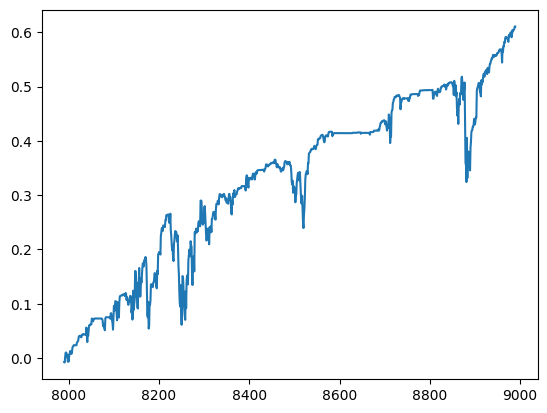

In [336]:
plt.plot(pnl.cumsum())
plt.show()

In [337]:
baseline = y_test['forward_returns']

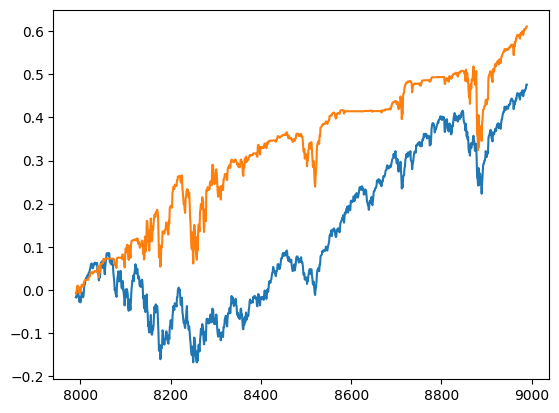

In [338]:
plt.figure()
plt.plot(baseline.cumsum())
plt.plot(pnl.cumsum())
plt.show()

In [339]:
sharpe = pnl.rolling(window=125).mean() / pnl.rolling(window=125).std() * np.sqrt(125)

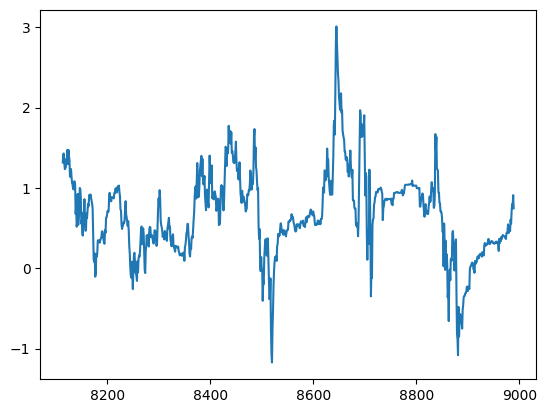

In [340]:
plt.plot(sharpe)

In [341]:
baseline_sharpe = baseline.rolling(window=125).mean() / baseline.rolling(window=125).std() * np.sqrt(125)

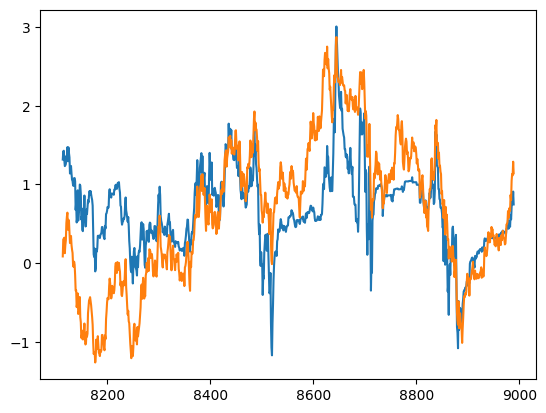

In [342]:
plt.plot(sharpe)
plt.plot(baseline_sharpe)